In [7]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [8]:
df = pd.read_csv('malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [9]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

## Plotting Wordcloud

In [10]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

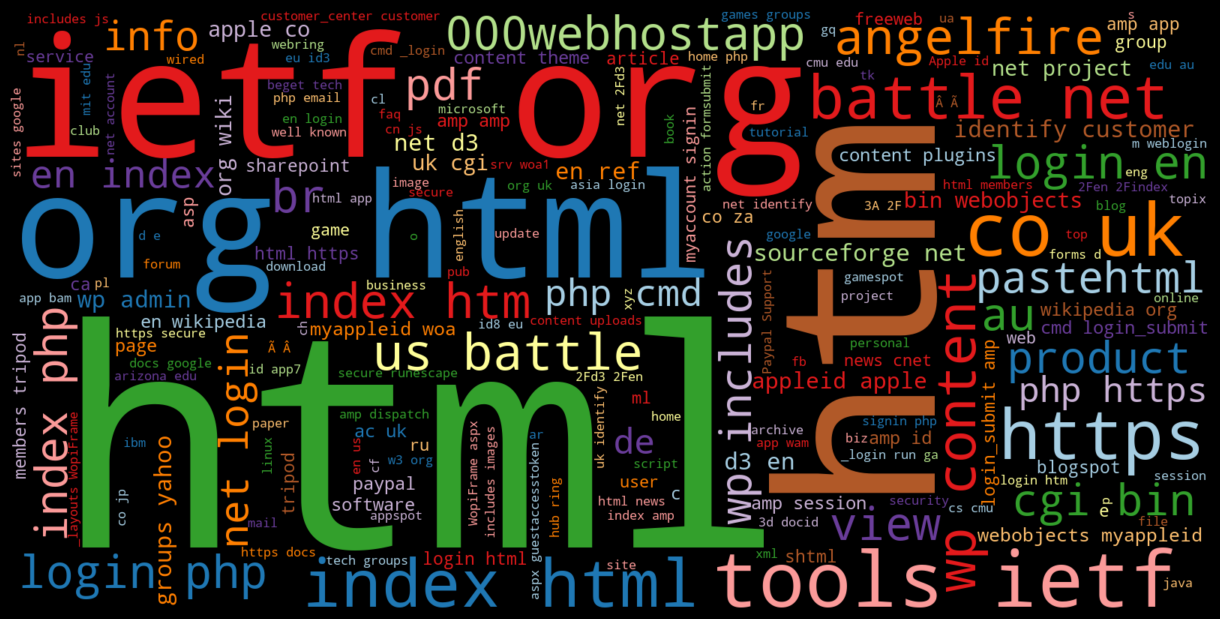

In [11]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phish_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

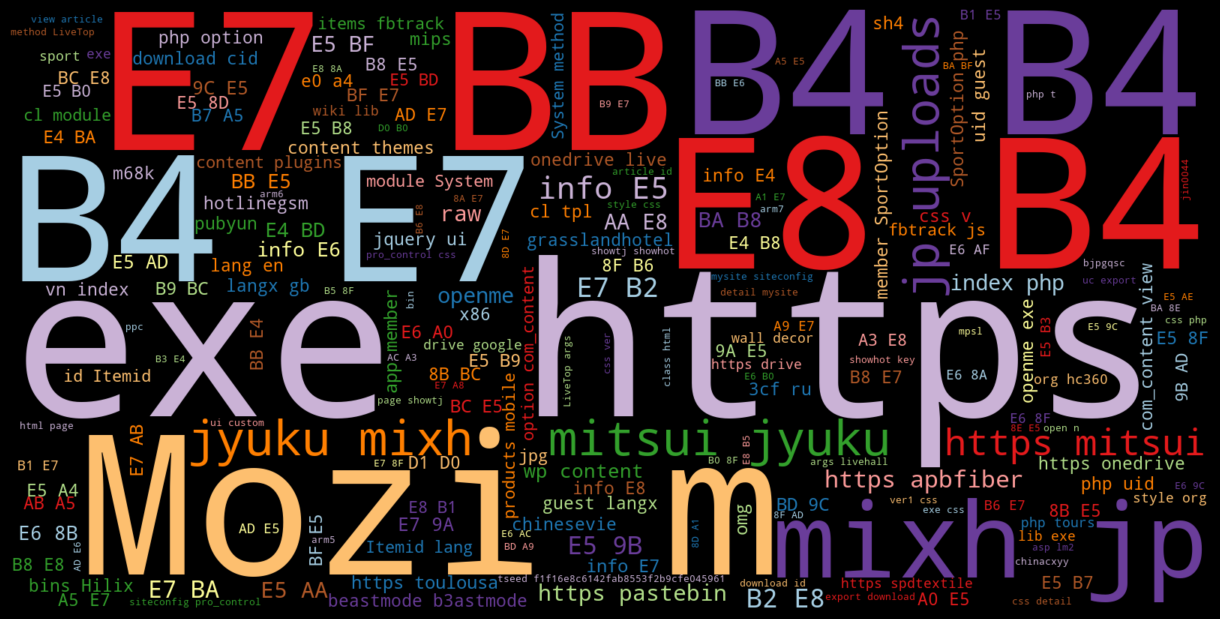

In [12]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(malware_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

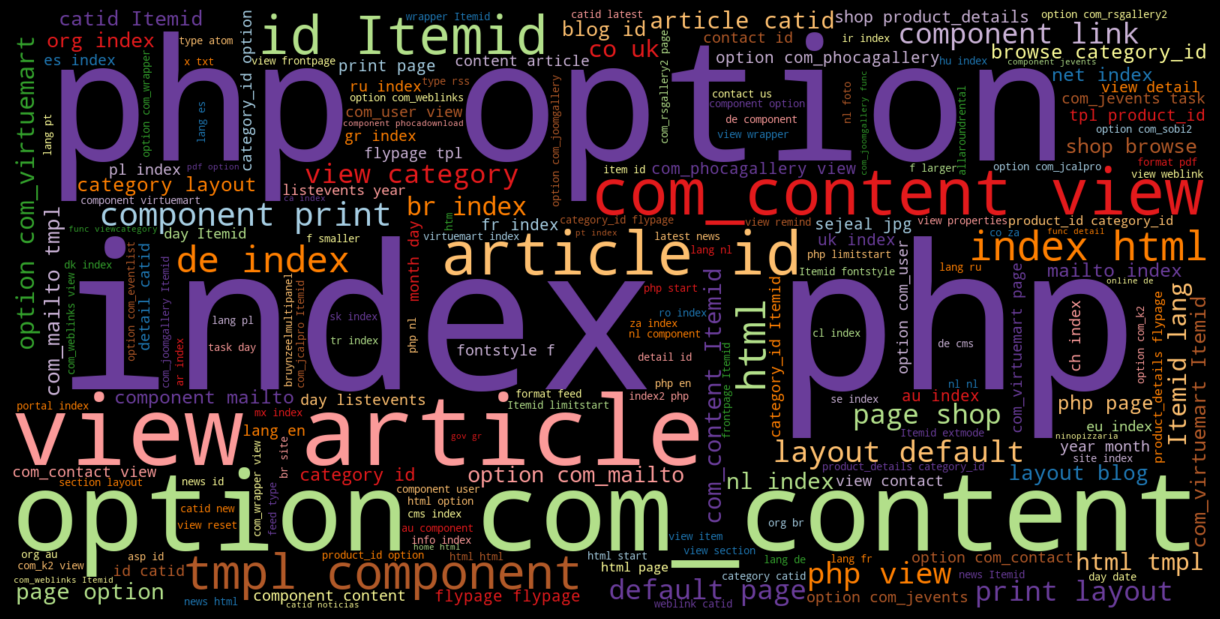

In [13]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(deface_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

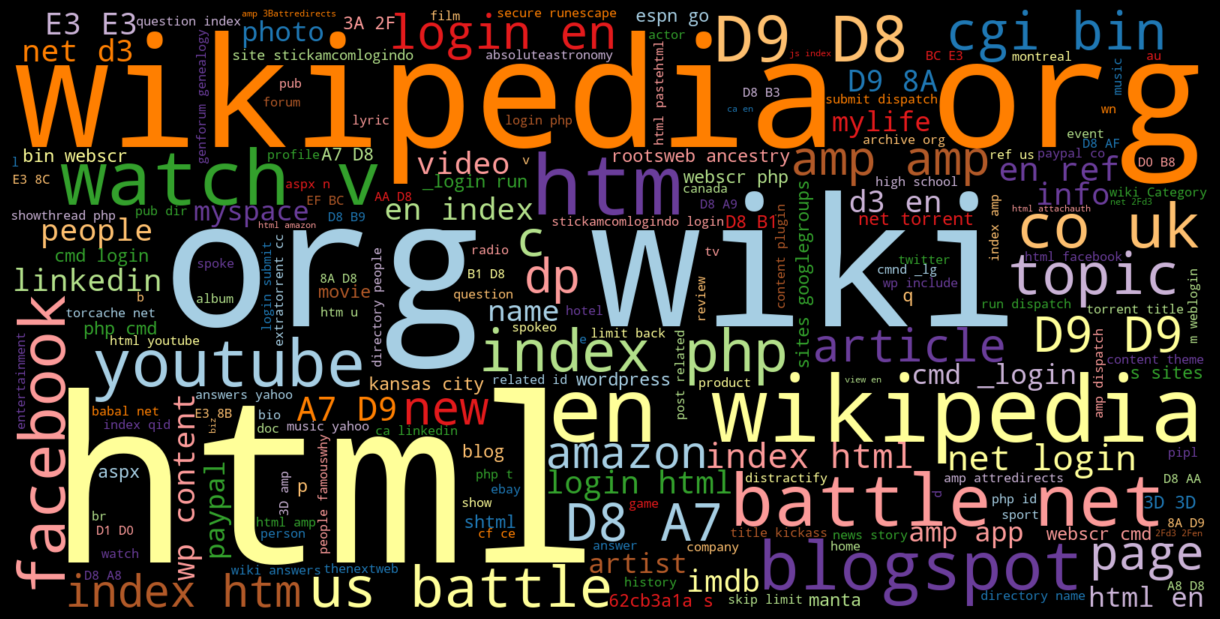

In [14]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [15]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [16]:
from urllib.parse import urlparse
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))


In [17]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))


In [19]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot
df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [20]:
def count_www(url):
    url.count('www')
    return url.count('www')
df['count-www'] = df['url'].apply(lambda i: count_www(i))
def count_atrate(url):
     
    return url.count('@')
df['count@'] = df['url'].apply(lambda i: count_atrate(i))
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [21]:
def count_https(url):
    return url.count('https')
df['count-https'] = df['url'].apply(lambda i : count_https(i))
def count_http(url):
    return url.count('http')
df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [22]:
def count_per(url):
    return url.count('%')
df['count%'] = df['url'].apply(lambda i : count_per(i))
def count_ques(url):
    return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))
def count_hyphen(url):
    return url.count('-')
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))
def count_equal(url):
    return url.count('=')
df['count='] = df['url'].apply(lambda i: count_equal(i))
def url_length(url):
    return len(str(url))
#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length
def hostname_length(url):
    return len(urlparse(url).netloc)
df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))
df.head()
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [14]:
!pip install tld

                                              0.0/263.8 kB ? eta -:--:--
     ----                                    30.7/263.8 kB 1.3 MB/s eta 0:00:01
     -----                                 41.0/263.8 kB 487.6 kB/s eta 0:00:01
     ---------------                      112.6/263.8 kB 819.2 kB/s eta 0:00:01
     -----------------------------          204.8/263.8 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 263.8/263.8 kB 1.2 MB/s eta 0:00:00


In [23]:
from urllib.parse import urlparse
from tld import get_tld
import os.path
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))
#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [24]:
#Now we are dropping URL,Google_index and tld columns
df = df.drop("google_index",1)
df = df.drop("url",1)

C:\Users\YASIR\AppData\Local\Temp\ipykernel_11252\750730871.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("google_index",1)
C:\Users\YASIR\AppData\Local\Temp\ipykernel_11252\750730871.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("url",1)


In [27]:
df.columns

Index(['type', 'count.', 'use_of_ip', 'abnormal_url', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'count-digits', 'count-letters',
       'fd_length', 'tld_length'],
      dtype='object')

In [25]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

# EDA (Exploratory Data Analysis) 

### 1.Distribution of use_of_ip

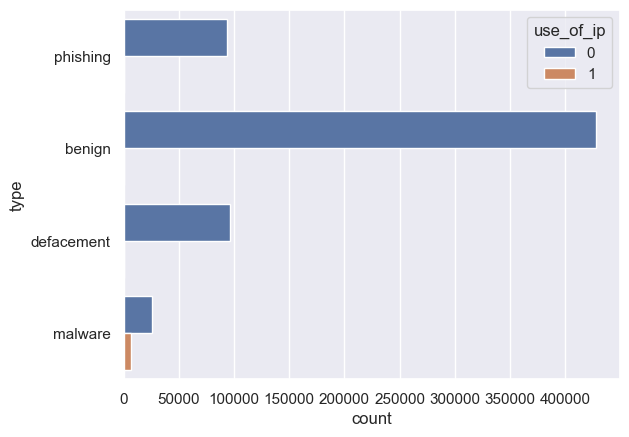

In [26]:
import seaborn as sns 
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="use_of_ip")

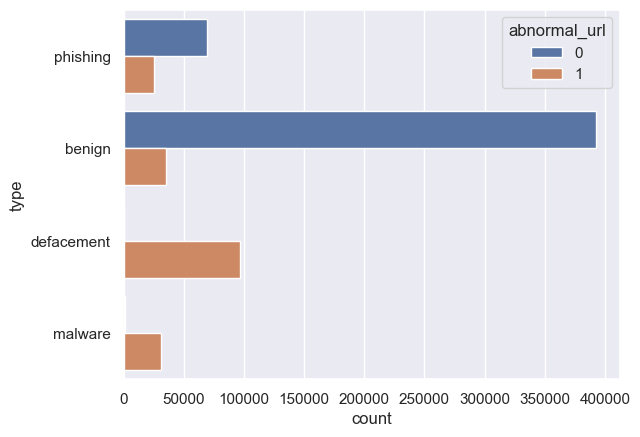

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="abnormal_url")

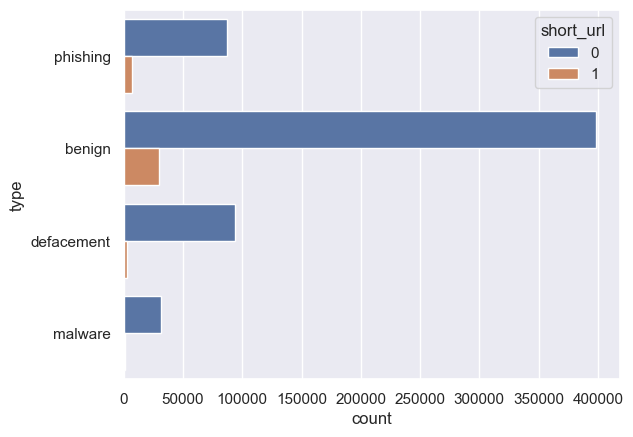

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="short_url")

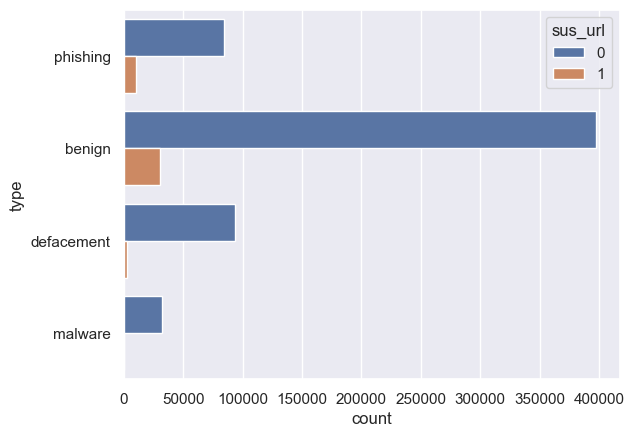

In [29]:
#Distributiob of suspcious_URL
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="sus_url")

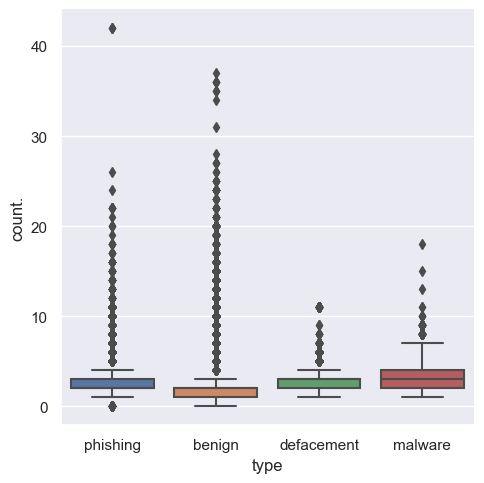

In [30]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="count.", kind="box",data=df)

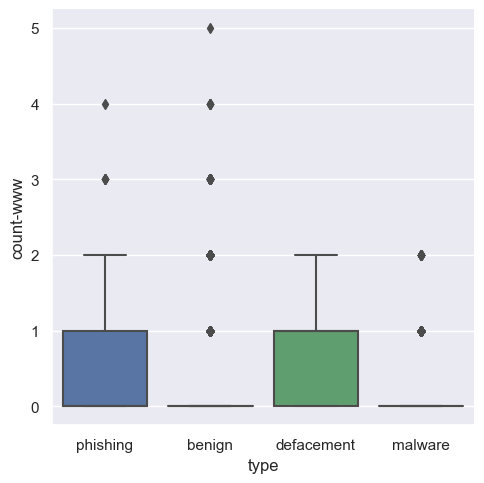

In [31]:
#Distributiob of count www
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="count-www", kind="box",data=df)

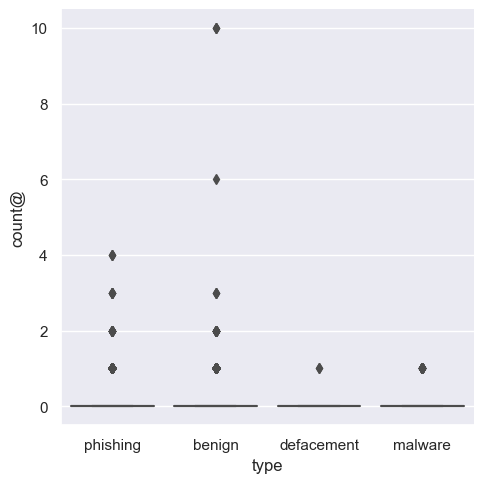

In [32]:
#Distributiob of count@
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="count@", kind="box",data=df)

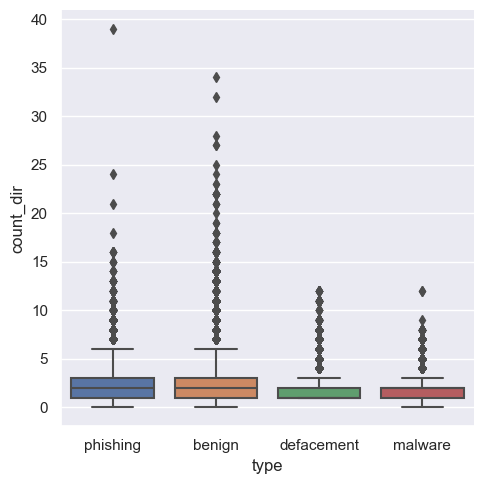

In [33]:
#Distribution of count of directory
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="count_dir", kind="box",data=df)

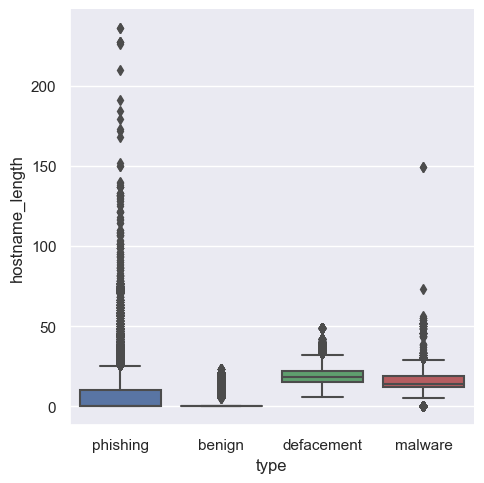

In [34]:
#Distribution of hostname length
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="hostname_length", kind="box",data=df)

### Target Variable Label Encoding

In [35]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [36]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [37]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


### Train Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

### 1. Random Forest Classifier

In [39]:
# Random Forest Model
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


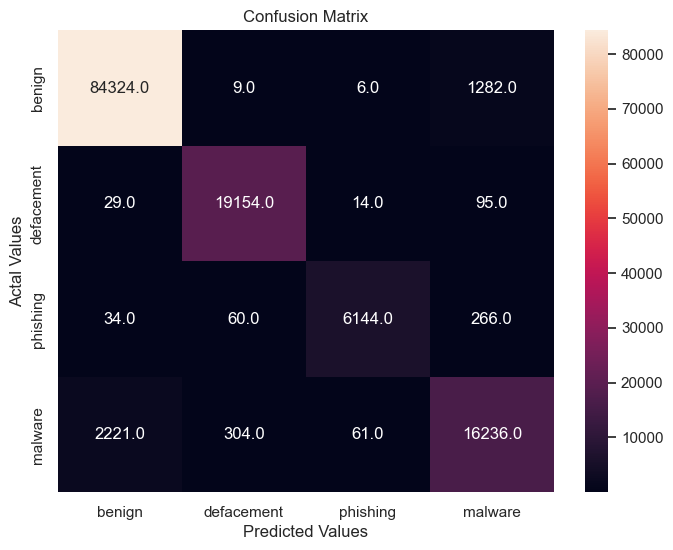

In [40]:
#since random forest model has highest accuracy, we build confusion matrix and check feature importance for it
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

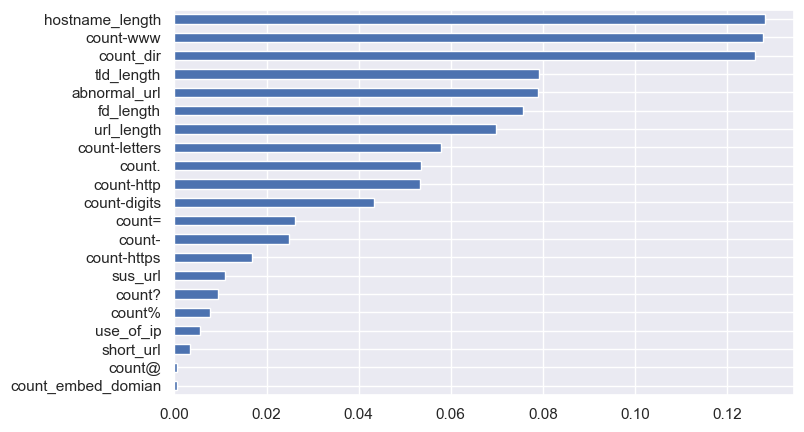

In [42]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(8, 5))

### 2. Light GBM Classifier

In [43]:
# Light GBM Classifier
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)
y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

C:\Users\YASIR\.conda\envs\MaliciousURL_Detection_Using_ML\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


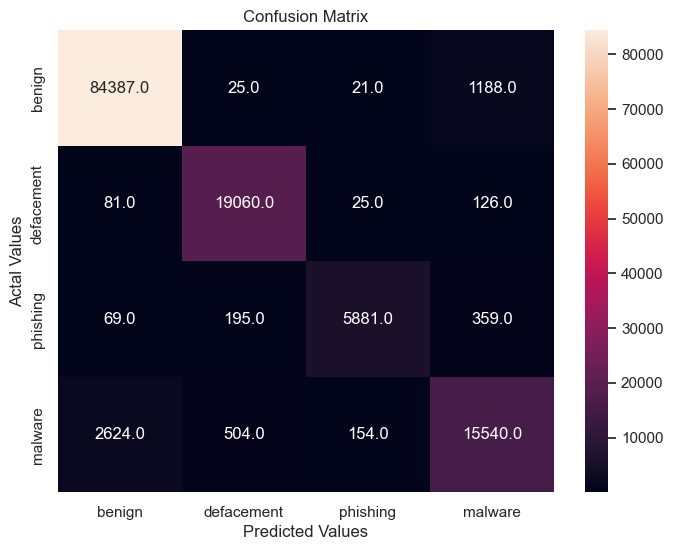

In [45]:
#we build confusion matrix and check feature importance for it
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### 3. XG BOOST

In [47]:
#XGboost
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_xg = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.92      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


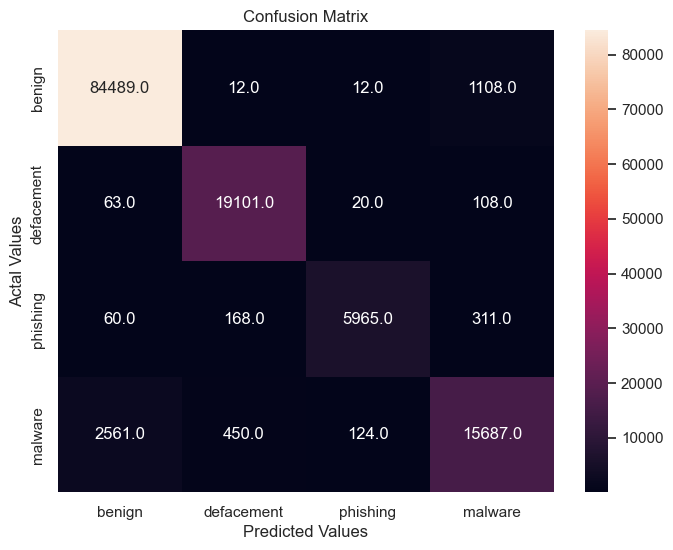

In [48]:
#we build confusion matrix and check feature importance for it
cm = confusion_matrix(y_test, y_pred_xg)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()